# Advanced Algorithms and Parallel Programming
## Summer Session Project on Advanced Algorithms
## Student: Samuel Polo - 10670388

# Graph Generator Notebook

In [1]:
#First, we import the needed libraries.
import graph_tool.all as gt 
import numpy as np

## Restrictions on Graph Generation
In order that a graph G = (V, E, d, w) have well-defined physical meaning
as a circuit, we place nonnegativity restrictions on the propagation delays
d(v) and the register counts w(e):

D1. The propagation delay d(v) is nonnegative for each vertex v belonging to V.

W1. The register count w(e) is a nonnegative integer for each edge e belonging to E.
We also impose the restriction that there be no directed cycles of zero weight:

W2. In any directed cycle of G, there is some edge with (strictly) positive
register count.

In [146]:
def sample_k(): #Sample to generate the In and Out Degree of each node in the graph. 
    #Taken from Graph-Tool documentation: A degree sampler function which is called without arguments, and returns a 
    #tuple of ints representing the in and out-degree of a given vertex (or a single int for undirected graphs, 
    #representing the out-degree).
    inOutDegree = np.random.randint(maxNodeDegree, size=2)
    if (inOutDegree[0] == 0): #Since all the graph needs to be connected, we impose at least one edge for each node.
        inOutDegree[0] = 1
    if (inOutDegree[1] == 0): #Since all the graph needs to be connected, we impose at least one edge for each node.
        inOutDegree[1] = 1
    return inOutDegree

Complexity of sample_k(): O(1)

In [268]:
def graphGenerator(nodes_size, delayRange=None, simpleDelayArray=True, weightRange=3, seed=None):
    #The following function generates a random graph with the following inputs:
    #nodes_size: number of vertices/nodes in the graph.
    #delayRange: specifies the range from [0-delayRange] in order to create an array of propagation delay.
    #simpleDelayArray: if it's true, the propagation delay of each index will be equal to the index of the vertex.
    #seed: a certain seed can be stated in order for the results to be totally reproducible. 
    #In order to do a quick test of the graph generator, the default values for a graph generation is to create
    #a graph with simple (random) values for the weight and simple values for the propagation delay of the index.
    
    if(seed!= None): #In order to make our data reproducible, we put a certain seed. 
            
        gt.seed_rng(seed)

        np.random.seed(seed)
        
    g = gt.random_graph(nodes_size, sample_k) #Execute graph_tool random graph generator with a certain numbers of nodes and
                                              #the sample_k
    
    edge_weight = g.new_edge_property("double") #Add a property to each edge of the graph.
    g.edge_properties["weight"] = edge_weight   #Rename that property to use it in the code as: g.ep.weight
    cap = g.new_vertex_property("int")          #Add a property to each vertex of the graph.
    g.vertex_properties["cap"] = cap            #Rename that property to use it in the code as: g.vp.cap
    
    #Note: the name "cap" was used as a placeholder of "propagation delay" since it's similar to a flow problem.
    #The name is just for intuitive purposes and doesn't change the internal logic of any algorithm. 

    #The weight of an edge will be a random positive number between 0 and weightRange (default value: 3). 
        
    for edge in g.edges():
        g.ep.weight[edge] = np.random.randint(weightRange, size=1)[0] 

    if (simpleDelayArray): #If it's true, the propagation delay array d(v) will be the index of the node. e.g d(0) = 0; d(4) = 4
            
        for vertex in g.vertices(): #Simple propagation delay creation. 
            g.vp.cap[vertex] = int(vertex)
    
    else:
        delayArray = np.random.randint(delayRange, size=nodes_size)
        for i in range(nodes_size): 
            g.vp.cap[i] = delayArray[i]
    
    for c in gt.all_circuits(g): #We do this validation in order to respect constraint W2.
        #print(c) Print each cycle of the graph. 
        pathSum = 0
        for item in range(len(c)-1):
            pathSum = pathSum + g.ep.weight[g.edge(c[item],c[item+1])]
            #print(pathSum)
        #Final edge sum: (edge(initial node of the cycle,last node before initial node))
        pathSum = pathSum + g.ep.weight[g.edge(c[item+1],c[0])]
        if(pathSum == 0): #If a cycle with zero weight is found.
            print("Cycle with Zero weight detected!")
            g.ep.weight[g.edge(c[item+1],c[0])] = 1 #Add 1 to the last edge in order to make it different from 0.
                                                    #This is a simply solution in order to not violate constraint W2. 
            print("Edge: %s modificated with value 1!" % (g.edge(c[item+1],c[0])))
        else:
            print("Path SUM: %s" % (pathSum))
    
    gt.graph_draw(g, vertex_text=g.vertex_index, edge_text=g.ep.weight) #Graph the draw for visualization.
    return g

Note: the complexities of the library methods were taken straight from the documentation [2].

### Complexity of:
    -gt.random_graph(): O(V+E) if parallel edges are allowed, and O(V+E×n-iter) if parallel edges are not allowed.
    -for edges: O(E)
    -for vertex: O(V)
    -gt.all_circuits(): O[(V+E)(C+1)] , where C is the number of circuits.
    -Nested loop: O([(V+E)(C+1)]*M), where M is the number of elements in the circuit.
    
    -graph_generator(): O([(V+E)(C+1)]*M)

In [283]:
def graphCorrelator(nodes_size, seed=None): 
    #Create a Graph correlator based on the examples from Leiserson and Saxe. This generator can be seen as a specific case
    #of the previous graph generator where the host node has 0 propagation delay, "bottom" nodes have 3 propagation delay and
    #upper nodes have 7. Weights are a number in the range [0-5].
    if (nodes_size < 3):
        print("Error: a correlator must have a number of nodes equal or greater than 3.")
    elif (nodes_size == 3):
        g = gt.Graph() #Base Case
    
        edge_weight = g.new_edge_property("double") #Add a property to each edge of the graph.
        g.edge_properties["weight"] = edge_weight   #Rename that property to use it in the code as: g.ep.weight
        cap = g.new_vertex_property("int")          #Add a property to each vertex of the graph.
        g.vertex_properties["cap"] = cap            #Rename that property to use it in the code as: g.vp.cap
        
        g.add_vertex(3)
        g.vp.cap[0] = 0
        g.vp.cap[1] = 3
        g.vp.cap[2] = 7
        
        g.add_edge(0,1)
        g.add_edge(1,2)
        g.add_edge(2,0)
        
        for edge in g.edges():
            g.ep.weight[edge] = np.random.randint(3, size=1)[0] 
        
    else: #General Case
        g = gt.Graph()
    
        edge_weight = g.new_edge_property("double") #Add a property to each edge of the graph.
        g.edge_properties["weight"] = edge_weight   #Rename that property to use it in the code as: g.ep.weight
        cap = g.new_vertex_property("int")          #Add a property to each vertex of the graph.
        g.vertex_properties["cap"] = cap            #Rename that property to use it in the code as: g.vp.cap
        
        g.add_vertex(nodes_size) #Create the specific number of vertex in the graph. 
        
        if (nodes_size % 2 == 0):
            numberOf7 = (nodes_size//2)-1
        else:
            numberOf7 = (nodes_size//2)
        
        numberOf3 = (nodes_size//2)
        
        #Creation of "bottom circuit" 
        for i in range(numberOf3): #Creation of nodes with 3 as propagation delay. 
            g.add_edge(i,i+1)
        
        i = i + 1 #Increase i in order to connect the appropiate edges.
        
        #Creation of "upper circuit" 
        for j in range(i, i+numberOf7): #Creation of nodes with 7 as propagation delay.
            g.add_edge(j,j+1)
        
        #Final Edge from last vertex with 7 to Host 0:
        g.add_edge(nodes_size-1, 0)
        
        #Intermediate Edges (from vertex with propagation delay 3 to 7)
        for i in range(1, numberOf3):
                g.add_edge(i, nodes_size-i)
        
        #Propagation Delay Assignation
        for i in range(1, numberOf3+1): #We add 1 to numberOf3 in order to include the final vertex of d(v) = 3.
            g.vp.cap[i] = 3
        
        for j in range(i+1, nodes_size):
            g.vp.cap[j] = 7
        
        #Weight Assignation
        for edge in g.edges():
            g.ep.weight[edge] = np.random.randint(3, size=1)[0] 
        
    if (nodes_size >= 3):
        for c in gt.all_circuits(g): #We do this validation in order to respect constraint W2.
            pathSum = 0
            for item in range(len(c)-1):
                pathSum = pathSum + g.ep.weight[g.edge(c[item],c[item+1])]

            pathSum = pathSum + g.ep.weight[g.edge(c[item+1],c[0])]
            if(pathSum == 0): #If a cycle with zero weight is found.
                print("Cycle with Zero weight detected!")
                g.ep.weight[g.edge(c[item+1],c[0])] = 1 #Add 1 to the last edge in order to make it different from 0.
                                                        #This is a simply solution in order to not violate constraint W2. 
                print("Edge: %s modificated with value 1!" % (g.edge(c[item+1],c[0])))
                
        gt.graph_draw(g, vertex_text=g.vp.cap, edge_text=g.ep.weight) #Graph the draw for visualization.
        return g

### Complexity of:
    -gt.all_circuits(): O[(V+E)(C+1)] , where C is the number of circuits.
    -Nested loop: O([(V+E)(C+1)]*M), where M is the number of elements in the circuit.
    
    -graphCorrelator(): O([(V+E)(C+1)]*M)

## Creation of a Graph Example (Using General Graph Generator)

After executing the previous lines, we can easily create a default graph with the following command:

maxNodeDegree: maximum required node degree for each vertex of the graph.

graphGenerator(x): this will create a graph with x vertices with default values for the graph. (Simple weights and propagation delay)

Path SUM: 4.0
Path SUM: 7.0
Path SUM: 5.0
Path SUM: 5.0
Path SUM: 4.0
Path SUM: 4.0
Cycle with Zero weight detected!
Edge: (5, 4) modificated with value 1!
Path SUM: 2.0


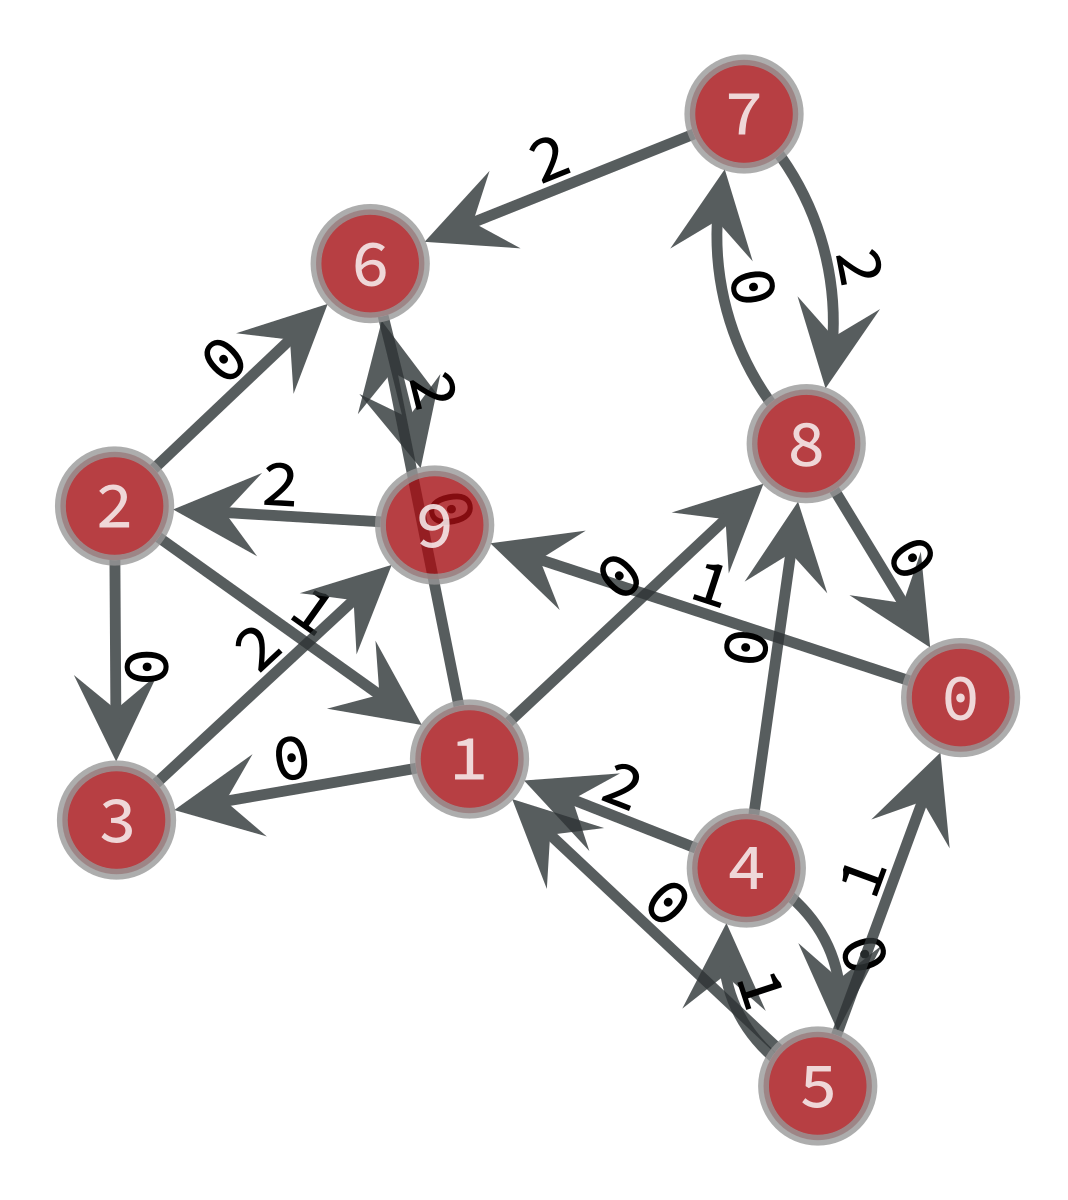

In [277]:
maxNodeDegree = 4 #Due to design decisions of the team of Graph-Tool, we are forced to declare the Max Node degree outside 
                  #of the generator in order to be used with the sample_k function. 
generatedGraph = graphGenerator(10)

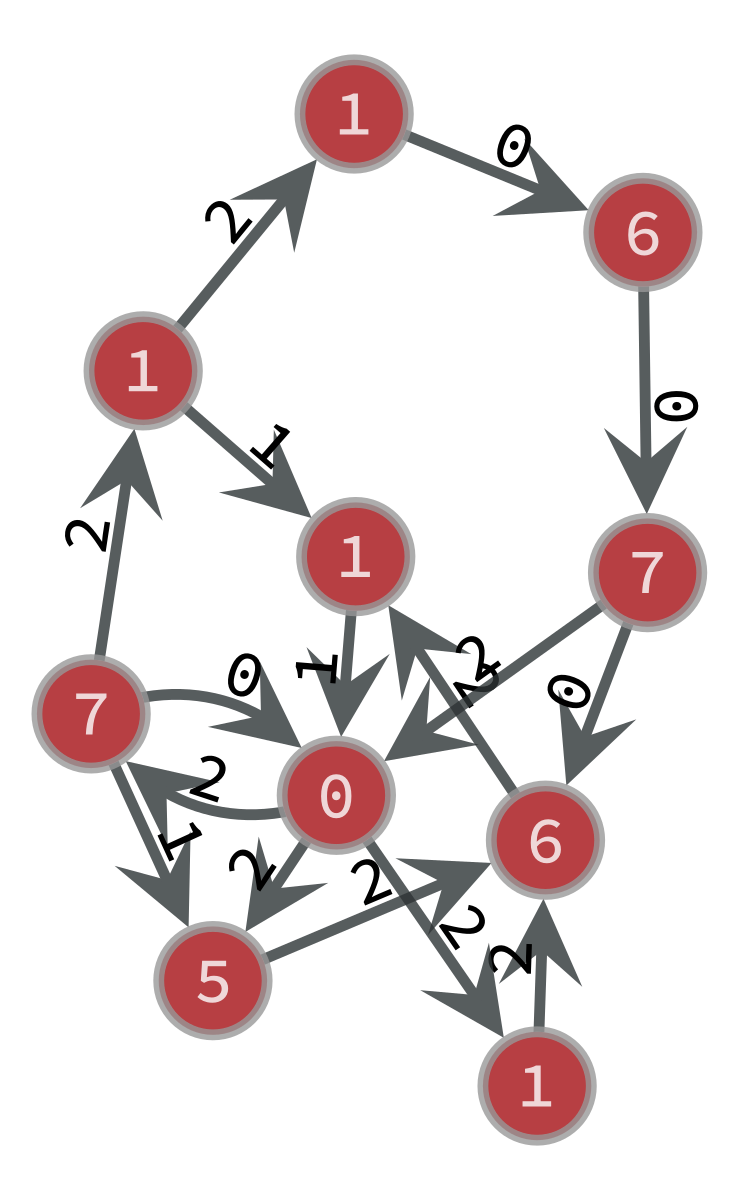

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f86c82641f0, at 0x7f86c82643a0>

In [275]:
g = gt.Graph(generatedGraph) #We can assign the newly created graph to another variable that will have a copy of the graph if
                             #we want to perform operations without affecting the original graph. 
gt.graph_draw(g, vertex_text=g.vp.cap, edge_text=g.ep.weight) #Draw the graph.

In [168]:
g.save("generatedGraph2.xml.gz") #We can save the graph in a file in order to use it in another notebooks. 

In [161]:
#This code snippet will show the behaviour of the graph if a cycle with zero weights is found. 
for i in range(1000):
    g = gt.random_graph(7, sample_k)
    print(g)
    print(g.num_edges())
    edge_weight = g.new_edge_property("double")
    g.edge_properties["weight"] = edge_weight
    for edge in g.edges():
    #print(edge)
        g.ep.weight[edge] = np.random.randint(3, size=1)[0] 
    #print(g.ep.weight[edge])

    cap = g.new_vertex_property("int")
    g.vertex_properties["cap"] = cap 

    for vertex in g.vertices():
        g.vp.cap[vertex] = int(vertex)
    for c in gt.all_circuits(g):
        print(c)
        pathSum = 0
        for item in range(len(c)-1):
            pathSum = pathSum + g.ep.weight[g.edge(c[item],c[item+1])]
            print(pathSum)
        #Final edge sum: (edge(initial node of the cycle,last node before initial node))
        pathSum = pathSum + g.ep.weight[g.edge(c[item+1],c[0])]
        if(pathSum == 0):
            print("Cycle with Zero weight detected!")
            g.ep.weight[g.edge(c[item+1],c[0])] = 1
            print("Edge: %s modificated with value 1!" % (g.edge(c[item+1],c[0])))
        else:
            print("Path SUM: %s" % (pathSum))

<Graph object, directed, with 7 vertices and 12 edges, at 0x7f86c82897f0>
12
[0 4 3 2 1]
1.0
3.0
3.0
5.0
Path SUM: 7.0
[0 4 3 2 5 1]
1.0
3.0
3.0
5.0
5.0
Path SUM: 7.0
[0 4 3 2 6 1]
1.0
3.0
3.0
4.0
5.0
Path SUM: 7.0
[1 4 3 2]
1.0
3.0
3.0
Path SUM: 5.0
[1 4 3 2 5]
1.0
3.0
3.0
5.0
Path SUM: 5.0
[1 4 3 2 6]
1.0
3.0
3.0
4.0
Path SUM: 5.0
[1 2]
2.0
Path SUM: 4.0
[1 2 5]
2.0
4.0
Path SUM: 4.0
[1 2 6]
2.0
3.0
Path SUM: 4.0
[2 6 4 3]
1.0
1.0
3.0
Path SUM: 3.0
<Graph object, directed, with 7 vertices and 12 edges, at 0x7f86c8e318e0>
12
[0 3 1 6]
2.0
3.0
5.0
Path SUM: 5.0
[0 3 1 6 5]
2.0
3.0
5.0
5.0
Path SUM: 6.0
[0 3 1 6 5 2 4]
2.0
3.0
5.0
5.0
7.0
7.0
Path SUM: 8.0
[1 6]
2.0
Path SUM: 3.0
[2 6 5]
0.0
0.0
Path SUM: 2.0
[5 6]
2.0
Path SUM: 2.0
<Graph object, directed, with 7 vertices and 10 edges, at 0x7f86cc3fbc40>
10
[0 1]
0.0
Cycle with Zero weight detected!
Edge: (1, 0) modificated with value 1!
[0 5 2 3 6 1]
2.0
2.0
2.0
4.0
6.0
Path SUM: 7.0
[2 3 6 4 5]
0.0
2.0
3.0
5.0
Path SUM: 5.0
[2 4 5]
0

## Creation of a Graph Example (Using Correlator Generator)

We can also easily create a correlator graph like the ones in [1]  with the following command:

graphCorrelator(x): this will create a correlator-circuit type graph with x vertices. Some with propagation delay 3 and others with 7. The weights will be randomized between 0 and 5 as a quick test.

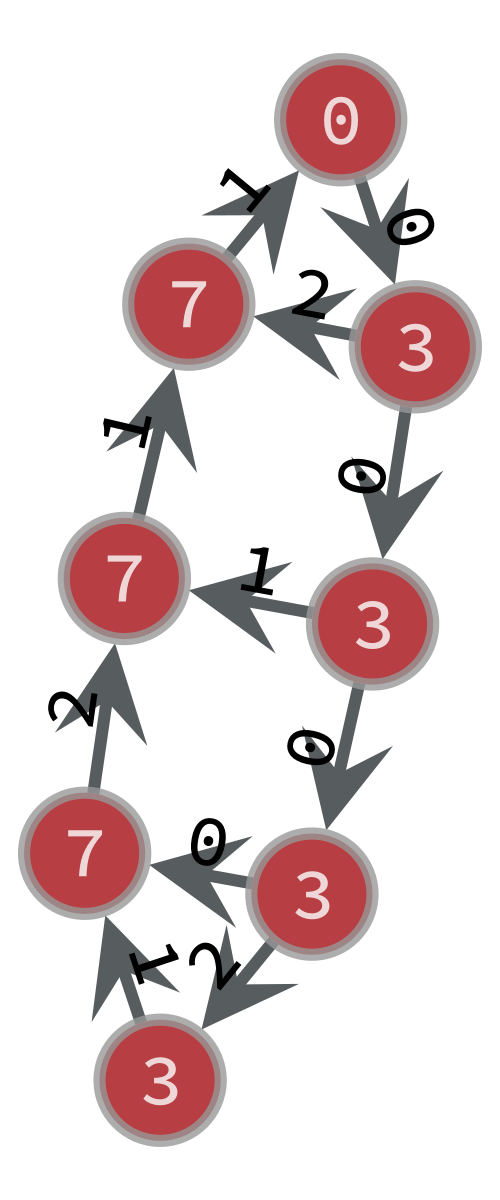

In [267]:
correlator = graphCorrelator(8)
correlator.save("correlatorGraph.xml.gz")

Path SUM: 11.0
Path SUM: 10.0
Path SUM: 5.0
Path SUM: 5.0


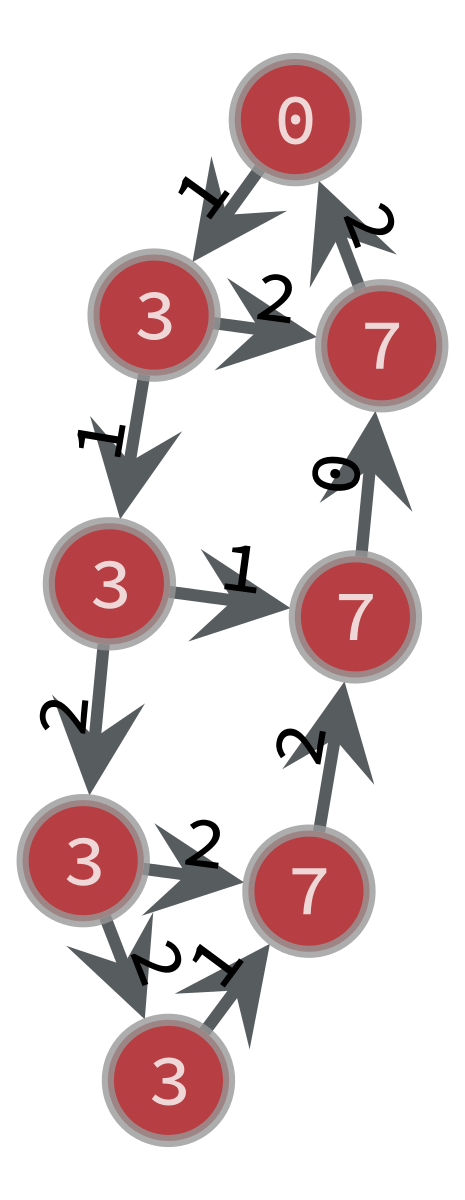

<Graph object, directed, with 8 vertices and 11 edges, 1 internal vertex property, 1 internal edge property, at 0x7f86c8942eb0>

In [294]:
graphCorrelator(8)

## References

[1] Leiserson, C.E., Saxe, J.B. Retiming synchronous circuitry. Algorithmica 6, 5–35 (1991). https://doi.org/10.1007/BF01759032

[2] Official Graph-Tool Documentation: https://graph-tool.skewed.de/static/doc/index.html